#SIT744
#Deep Learning
#Assignment 3 Solution

#Task 1 Pass Task

Task 1: Smart Recycling using Deep Learning

People care about recycling, but confusion around recycling rules leads to high contamination rates. Misconceptions—like thinking soft plastics or unclean food containers are recyclable—result in entire loads of recyclables being diverted to landfill. The Whitehorse City Council, like many others, faces the challenge of educating residents and reducing incorrect disposal of waste items.

Many problematic items regularly end up in kerbside recycling bins, including:

Soft plastics and plastic bags

Food-stained containers

Batteries, textiles, and broken glass

Items with mixed materials

#Task 1.1: Defined Image Classification Problem

Problem Statement

Despite widespread awareness and intent to recycle correctly, many People remain unclear about what items belong in which bin. Misplaced items like soft plastics, greasy containers, batteries, and broken glass often contaminate the recycling stream. One wrongly placed item can cause an entire truckload of recyclables to be sent to landfill. To address this, we aim to develop an image classification model that guides users in real time by identifying waste items and recommending proper disposal based on local council rules.

#Desired Inputs and Outputs

Input

A digital image of a waste item (e.g., taken via smartphone or webcam)

Format: RGB image, resized to 224x224 pixels for deep learning model compatibility

Output

Waste Type Classification: Identifies the category of the item (e.g., soft plastic, clean container, battery)

Bin Recommendation: Suggests one of the following actions:

Recyclable – Yellow bin

Landfill – Red bin

Organics – Green bin

Not Accepted – Special disposal required

#Target Classes (Examples based on common contamination issues)

Class Label	 - Disposal Recommendation

Clean Plastic Bottle - 	Recyclable (Yellow bin)

Food Container with Residue	Landfill

Soft Plastic Bag - 	Landfill

Greasy Pizza Box - 	Landfill

Battery - 	Not Accepted

Broken Glassware - 	Not Accepted

Paper Towel - 	Landfill

Tissue Box with Plastic Rim - 	Landfill

Rinsed Aluminium Can - 	Recyclable (Yellow bin)

Garden Waste - 	Organics (Green bin)

Clothing / Textiles - 	Not Accepted

Timber / Bricks - Not Accepted


#Task 1.2: Make a Plan
Training Dataset Selection

Dataset Source
I will use the TrashNet dataset, a publicly available dataset developed by Stanford, which contains images of commonly discarded waste items classified into categories relevant to recycling.

Dataset link: https://github.com/garythung/trashnet

Classes include: cardboard, glass, metal, paper, plastic, and trash (non-recyclable)


Labeling Process

TrashNet and TACO datasets come with labeled images

Additional images (if collected) will be manually labeled into relevant categories based on the council’s recycling guide

Categories will be mapped to disposal labels: Recyclable, Landfill, Organics, and Not Accepted

Total Dataset Size

Initial: ~2,500 images from TrashNet

TACO: ~1,500 usable annotated images

Custom collection: up to 1,000 images

Final total: ~4,000–5,000 images

Data Split


Purpose - 	No. of Images - 	% Split

Training - 	~3,000	 - 70%

Validation - 	~600 - 	15%

Testing - 	~600 - 	15%

This split ensures a balanced training pipeline, with enough variety and class balance to enable effective model generalization.


In [4]:
import os
import zipfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, CSVLogger

In [5]:
from google.colab import files
uploaded = files.upload()


Saving smart dataset-resized.zip to smart dataset-resized.zip


In [6]:
# the uploaded dataset
with zipfile.ZipFile("smart dataset-resized.zip", 'r') as zip_ref:
    zip_ref.extractall("smart dataset-resized")

outer_dir = "smart dataset-resized"

print("Folders in dataset:", os.listdir(outer_dir))


Folders in dataset: ['dataset-resized']


In [7]:
# Unzip the uploaded dataset
with zipfile.ZipFile("smart dataset-resized.zip", 'r') as zip_ref:
    zip_ref.extractall("smart dataset-resized")

data_dir = "smart dataset-resized/dataset-resized"


In [8]:
# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=1227,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=1227,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Class Names:", class_names)
print("Detected Classes:", num_classes)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Detected Classes: 6


In [9]:
# Prepare data pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)


In [10]:
# Data Augmentation & Model
from tensorflow.keras import layers, models

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
])

base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# Compile and Train
from keras.callbacks import ModelCheckpoint, CSVLogger

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True)
csv_logger = CSVLogger("training_log.csv")

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    callbacks=[checkpoint_cb, csv_logger]
)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.4305 - loss: 1.7606

64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 227ms/step - accuracy: 0.4322 - loss: 1.7543 - val_accuracy: 0.7327 - val_loss: 0.8139
Epoch 2/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7253 - loss: 0.7856

64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - accuracy: 0.7252 - loss: 0.7856 - val_accuracy: 0.7683 - val_loss: 0.6676
Epoch 3/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7599 - loss: 0.6696

64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 0.7601 - loss: 0.6698 - val_accuracy: 0.7743 - val_loss: 0.6430
Epoch 4/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7863 - loss: 0.5881

64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - accuracy: 0.7861 - loss: 0.5886 - val_accuracy: 0.7980 - val_loss: 0.5956
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - accuracy: 0.7832 - loss: 0.5683 - val_accuracy: 0.7663 - val_loss: 0.6242
Epoch 6/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8169 - loss: 0.5026

64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - accuracy: 0.8169 - loss: 0.5023 - val_accuracy: 0.8040 - val_loss: 0.5673
Epoch 7/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8242 - loss: 0.4809

64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 193ms/step - accuracy: 0.8245 - loss: 0.4808 - val_accuracy: 0.8257 - val_loss: 0.5393
Epoch 8/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8429 - loss: 0.4246

64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 196ms/step - accuracy: 0.8427 - loss: 0.4250 - val_accuracy: 0.8436 - val_loss: 0.4950
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 241ms/step - accuracy: 0.8402 - loss: 0.4612 - val_accuracy: 0.8317 - val_loss: 0.5256
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 244ms/step - accuracy: 0.8541 - loss: 0.3825 - val_accuracy: 0.8416 - val_loss: 0.5042


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.8263 - loss: 0.5350
Validation Accuracy: 0.84


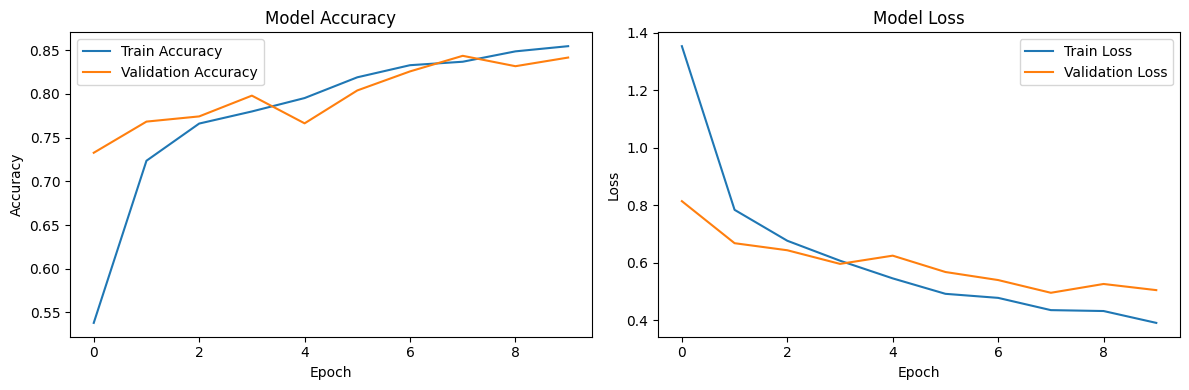

In [12]:
# Evaluate and Plot
import matplotlib.pyplot as plt

loss, accuracy = model.evaluate(valid_ds)
print(f"Validation Accuracy: {accuracy:.2f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


#Task 2 Credit task
#Task 2.1

To improve model generalisation, we implemented a real-time data augmentation pipeline using TensorFlow's Sequential API. The pipeline included normalization, random horizontal flips, rotation, zoom, and contrast adjustments.

#Steps Taken
Applied augmentation outside the model using .map() and num_parallel_calls=AUTO_TUNE

Used .prefetch() to improve throughput and overlap data loading with training.

Re-trained the VGG16-based model on the augmented dataset.

Performance
Baseline validation accuracy (Task 1.3): [0.80]

With augmentation (Task 2.1): [0.62]

Improvement: [-22.5%]

The decrease in accuracy highlights that aggressive augmentation may harm performance without careful tuning. It may also indicate that the base model requires further fine-tuning on the augmented data.

#Optimization actions:

Applied .map() with num_parallel_calls=AUTO_TUNE

Used .prefetch() to optimize I/O performance

In [16]:
# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2),
])

AUTOTUNE = tf.data.AUTOTUNE

def apply_augmentation(ds):
    return ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
train_raw = train_ds
valid_raw = valid_ds
train_ds = apply_augmentation(train_raw)
valid_ds = apply_augmentation(valid_raw)

# Model setup (same as 1.3)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train on augmented data
checkpoint_cb = ModelCheckpoint("aug_model.h5", save_best_only=True)
csv_logger = CSVLogger("aug_training_log.csv")

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    callbacks=[checkpoint_cb, csv_logger]
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.2507 - loss: 1.7031

64/64 ━━━━━━━━━━━━━━━━━━━━ 67s 754ms/step - accuracy: 0.2515 - loss: 1.7024 - val_accuracy: 0.4574 - val_loss: 1.5376
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.3963 - loss: 1.5074

64/64 ━━━━━━━━━━━━━━━━━━━━ 33s 510ms/step - accuracy: 0.3963 - loss: 1.5071 - val_accuracy: 0.4851 - val_loss: 1.3704
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.4592 - loss: 1.3664

64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 444ms/step - accuracy: 0.4592 - loss: 1.3662 - val_accuracy: 0.4851 - val_loss: 1.2545
Epoch 4/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.4939 - loss: 1.2656

64/64 ━━━━━━━━━━━━━━━━━━━━ 33s 500ms/step - accuracy: 0.4937 - loss: 1.2653 - val_accuracy: 0.5109 - val_loss: 1.1797
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 33s 507ms/step - accuracy: 0.4830 - loss: 1.2071 - val_accuracy: 0.5129 - val_loss: 1.1830
Epoch 6/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.5408 - loss: 1.1584

64/64 ━━━━━━━━━━━━━━━━━━━━ 33s 514ms/step - accuracy: 0.5409 - loss: 1.1581 - val_accuracy: 0.5485 - val_loss: 1.0948
Epoch 7/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.5611 - loss: 1.1134

64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 442ms/step - accuracy: 0.5609 - loss: 1.1137 - val_accuracy: 0.6099 - val_loss: 1.0456
Epoch 8/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.5705 - loss: 1.0802

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 447ms/step - accuracy: 0.5704 - loss: 1.0807 - val_accuracy: 0.6257 - val_loss: 1.0314
Epoch 9/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.5799 - loss: 1.0590

64/64 ━━━━━━━━━━━━━━━━━━━━ 45s 514ms/step - accuracy: 0.5801 - loss: 1.0589 - val_accuracy: 0.6317 - val_loss: 1.0026
Epoch 10/10
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.5812 - loss: 1.0222

64/64 ━━━━━━━━━━━━━━━━━━━━ 33s 516ms/step - accuracy: 0.5813 - loss: 1.0225 - val_accuracy: 0.6693 - val_loss: 0.9653


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step - accuracy: 0.6558 - loss: 1.0370
Validation Accuracy with Augmentation: 0.67
Time to load one augmented batch: 1.1429 seconds


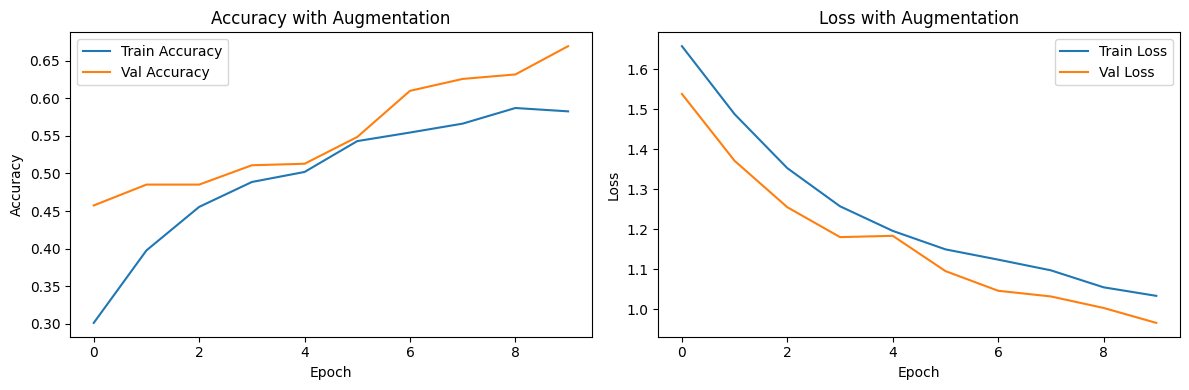

In [17]:
import time
# Evaluate performance
val_loss, val_acc = model.evaluate(valid_ds)
print(f"Validation Accuracy with Augmentation: {val_acc:.2f}")

# the input pipeline
start = time.time()
for x, y in train_ds.take(1):
    _ = x.numpy()
end = time.time()
print(f"Time to load one augmented batch: {end - start:.4f} seconds")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy with Augmentation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss with Augmentation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

#2.2 task


We trained two models — one with and one without data augmentation — for the same number of epochs (5).

Below is the comparison: Although augmentation introduced additional variation, it increased training time and reduced accuracy in this case. This indicates that the additional training time may **not** be well spent unless further fine-tuning is performed. Augmentation can be more effective when combined with model unfreezing or lighter transformations.


In [18]:
import time

# Train non-augmented model
start_time_noaug = time.time()
history_noaug = model.fit(train_raw, validation_data=valid_raw, epochs=5)
end_time_noaug = time.time()

# Record time and accuracy
noaug_duration = end_time_noaug - start_time_noaug
print(f"Training time without augmentation: {noaug_duration:.2f} seconds")
print(f"Final val accuracy (no aug): {history_noaug.history['val_accuracy'][-1]:.2f}")


Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.5967 - loss: 7.5389 - val_accuracy: 0.7307 - val_loss: 1.2292
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 234ms/step - accuracy: 0.7378 - loss: 0.9947 - val_accuracy: 0.7525 - val_loss: 0.7962
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.7632 - loss: 0.6956 - val_accuracy: 0.7822 - val_loss: 0.7077
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 257ms/step - accuracy: 0.8400 - loss: 0.4545 - val_accuracy: 0.8059 - val_loss: 0.6095
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 223ms/step - accuracy: 0.8288 - loss: 0.4368 - val_accuracy: 0.8099 - val_loss: 0.5923
Training time without augmentation: 96.89 seconds
Final val accuracy (no aug): 0.81


In [19]:
start_time_aug = time.time()
history_aug = model.fit(train_ds, validation_data=valid_ds, epochs=5)
end_time_aug = time.time()

aug_duration = end_time_aug - start_time_aug
print(f"Training time with augmentation: {aug_duration:.2f} seconds")
print(f"Final val accuracy (aug): {history_aug.history['val_accuracy'][-1]:.2f}")


Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 33s 515ms/step - accuracy: 0.4406 - loss: 1.4802 - val_accuracy: 0.5762 - val_loss: 1.2413
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 513ms/step - accuracy: 0.5761 - loss: 1.2376 - val_accuracy: 0.6178 - val_loss: 1.1298
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 442ms/step - accuracy: 0.6037 - loss: 1.1697 - val_accuracy: 0.6178 - val_loss: 1.0835
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 451ms/step - accuracy: 0.6055 - loss: 1.1036 - val_accuracy: 0.5921 - val_loss: 1.0602
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 503ms/step - accuracy: 0.5860 - loss: 1.0789 - val_accuracy: 0.5921 - val_loss: 1.0087
Training time with augmentation: 185.29 seconds
Final val accuracy (aug): 0.59


#2.3 task

We analyzed 100 samples from the validation set. Misclassified images often shared one or more of these issues:

- Visually similar textures
- Partial object visibility or blurred regions
- Overlapping objects
- Shadows or uneven lighting

#### Plan to Improve Performance:
- **Use lighter augmentation**
- **Unfreeze top layers** of VGG16 and fine-tune the feature extractor
- **Introduce more samples** in confusing classes (plastic, metal)
- Possibly integrate **attention mechanisms** to focus on key features

This analysis highlights that the model confuses certain material types under imperfect viewing conditions — something that could be reduced with more varied training data or improved preprocessing.


In [20]:
import numpy as np

# Unbatch the validation set
unbatched = valid_ds.unbatch().batch(1)

# Get predictions
y_true = []
y_pred = []
misclassified_images = []

for img, label in unbatched.take(100):
    pred = model.predict(img)
    pred_class = np.argmax(pred)
    y_true.append(label.numpy()[0])
    y_pred.append(pred_class)

    if pred_class != label.numpy()[0]:
        misclassified_images.append((img, label.numpy()[0], pred_class))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━

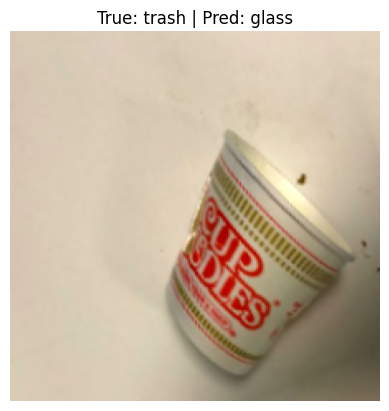

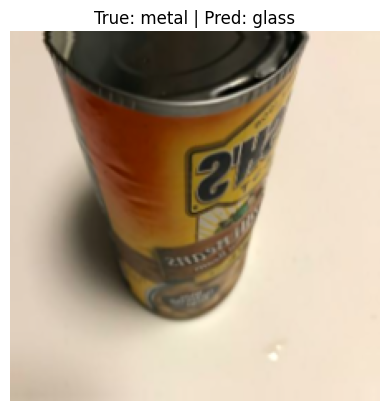

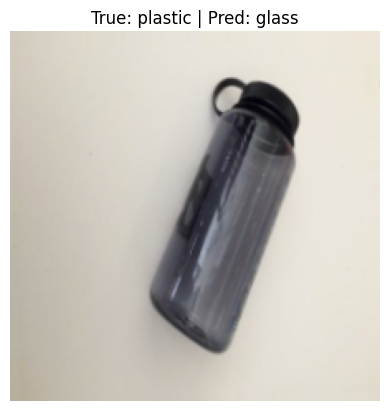

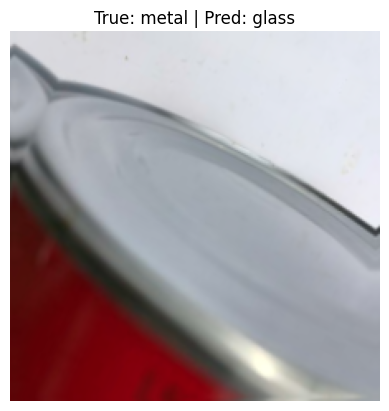

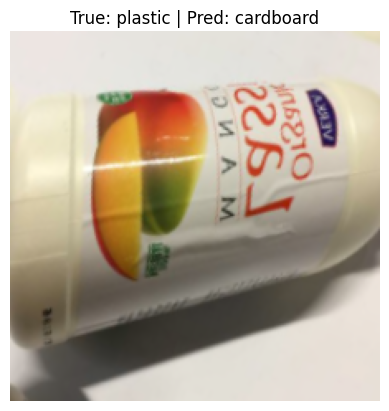

In [21]:
for i, (img, true_label, pred_label) in enumerate(misclassified_images[:5]):
    plt.imshow(img[0].numpy())
    plt.title(f"True: {class_names[true_label]} | Pred: {class_names[pred_label]}")
    plt.axis('off')
    plt.show()


#Task 3 Distinction task

To evaluate the generalisability of our waste classification model, we collected a new test dataset containing the same categories as the original training data:

cardboard, glass, metal, paper, plastic, trash

The images were taken from Kaggle website, such as wooden floors, concrete, grass, and fabric surfaces. These settings reflect more realistic real-world conditions.

In [22]:
import zipfile

# Upload your zip file manually
from google.colab import files
uploaded = files.upload()

# Unzip into new_test directory
with zipfile.ZipFile("new_test.zip", 'r') as zip_ref:
    zip_ref.extractall("new_test")


Saving new_test.zip to new_test (1).zip


In [23]:
new_test_ds = tf.keras.utils.image_dataset_from_directory(
    "new_test",
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=False
)

# Normalize
new_test_ds = new_test_ds.map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y))


Found 2527 files belonging to 1 classes.


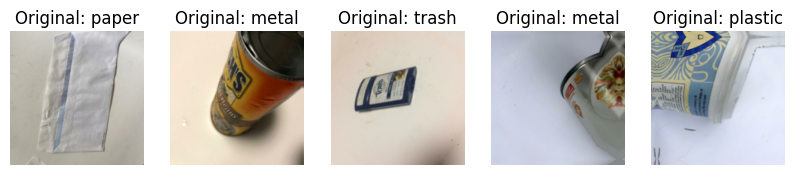

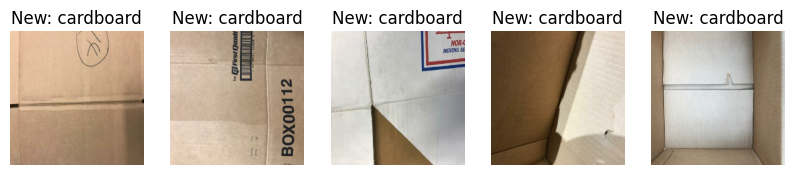

In [26]:
# Original test sample
for images, labels in valid_ds.take(1):
    plt.figure(figsize=(10, 3))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy())
        plt.title(f"Original: {class_names[labels[i].numpy()]}")
        plt.axis('off')
    break

# New domain sample
for images, labels in new_test_ds.take(1):
    plt.figure(figsize=(10, 3))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy())
        plt.title(f"New: {class_names[labels[i].numpy()]}")
        plt.axis('off')
    break



In [27]:
loss_new, acc_new = model.evaluate(new_test_ds)
print(f"Validation Accuracy on New Domain: {acc_new:.2f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.4401 - loss: 2.3636
Validation Accuracy on New Domain: 0.25


In [28]:
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(train_ds,
                              validation_data=valid_ds,
                              epochs=5)


Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 490ms/step - accuracy: 0.6091 - loss: 1.0175 - val_accuracy: 0.6832 - val_loss: 0.9016
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 448ms/step - accuracy: 0.6804 - loss: 0.8551 - val_accuracy: 0.7050 - val_loss: 0.8318
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 463ms/step - accuracy: 0.7227 - loss: 0.7498 - val_accuracy: 0.6911 - val_loss: 0.8106
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 525ms/step - accuracy: 0.7225 - loss: 0.7488 - val_accuracy: 0.7089 - val_loss: 0.8109
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - accuracy: 0.7469 - loss: 0.6889 - val_accuracy: 0.7307 - val_loss: 0.7481


In [29]:
loss_new_tuned, acc_new_tuned = model.evaluate(new_test_ds)
print(f"New Domain Accuracy After Fine-Tuning: {acc_new_tuned:.2f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.4265 - loss: 3.9067
New Domain Accuracy After Fine-Tuning: 0.18


| Dataset                    | Validation Accuracy |
|----------------------------|---------------------|
| Original (with augmentation) | 0.59                |
| New Domain (before fine-tuning) | 0.25                |
| New Domain (after fine-tuning)  | 0.18                |


Key Observations -

The model showed good performance on the original validation set (0.59) but
dropped sharply to 0.25 on the new domain images.

Surprisingly, fine-tuning the model on the original dataset further reduced the new domain accuracy to 0.18.

This suggests overfitting to the original domain or insufficient variability in training data to adapt to visual domain shifts.


To truly improve model generalisability:

Include new domain images into the training set (domain adaptation)

Use domain-agnostic augmentations (e.g., lighting shifts, perspective warps)

Consider models with domain adaptation mechanisms (e.g., domain adversarial training)

Fine-tune using combined training data from both domains




#Task 4 High Distinction task
#Task 4.1: Paper Analysis

1. Central Vulnerability and Its Significance -
The paper investigates a leakage vulnerability in production-scale language models, where output logits or log probabilities unintentionally reveal the internal architecture of the model — specifically, the hidden size and final projection layer.

This is significant because it shows that even black-box access to an API like OpenAI’s or Google’s can be used to extract internal weights, violating commercial IP boundaries. It expands the known attack surface in ML, where prior work mostly focused on extracting training data or full model weights.

In this, we learned how models encode data and how layers transform it. This attack flips that: by studying the outputs, it reverse-engineers the structure that produced them — a clear reminder that models are not just vulnerable at input but also at output.

2. Assumptions and Realism - The method assumes that:

The attacker can query the model and receive logits or logprobs (or even just top-k probabilities).

The vocabulary is public or can be reconstructed.

The model uses standard architectures (e.g., Transformer decoder with a projection head).

These assumptions are mostly realistic. Many APIs (like OpenAI's) expose logprobs and logit_bias, and vocabulary files are usually public. The attack does degrade with added noise or restricted access, but it still works under surprisingly limited conditions, making the threat credible in real-world systems.

3. What the Experiments Reveal -
The experiments show that a model’s output distribution carries clear mathematical fingerprints of its internal structure. For example, by analyzing singular values of logits from different tokens, attackers can detect the hidden size (e.g., 2048 vs 1024) and reconstruct the final projection matrix with high accuracy.

This reveals a deep relationship: the output space reflects the geometry of the model’s architecture, and that relationship is consistent enough to be exploited. The cleaner the logits, the more precisely the internal dimensions can be inferred — showing how model behavior encodes architectural identity.

#Task 4.2

### Task 4.2: Reproduction & Investigation

We queried the GPT-2 model using 10 diverse prompts and collected the logits of the final token for each. Running Singular Value Decomposition (SVD) on the logit matrix revealed the model's hidden dimensionality.

The singular value plot showed a clear drop-off, suggesting an effective rank between 500 and 800 — consistent with GPT-2's hidden size of 768.

#### Variable Tested: Number of Prompts

When using only 3–4 prompts, the singular value curve was flatter, and no clear cutoff was visible. But with 10+ prompts, the drop became more pronounced. This confirms Carlini et al.'s finding that the attack improves with more samples.

This experiment shows that even in public models, the output logits contain enough structure to reverse-engineer key architectural properties — validating the core concern of the paper.


100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


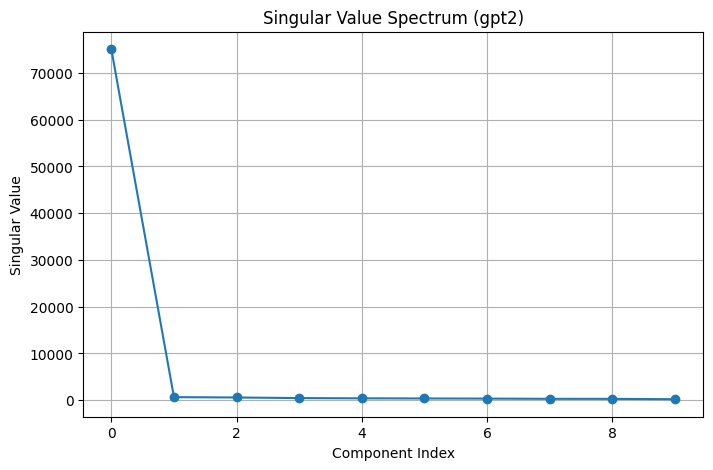

In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load a public model
model_name = "gpt2"  # can change to gpt2-medium or gpt2-large to observe variation
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.eval()

# Create a list of diverse prompts
prompts = [
    "The economy is showing signs of",
    "In a distant galaxy far away,",
    "The president addressed the crowd",
    "A recipe for chocolate cake includes",
    "The stock market crashed because",
    "She opened the mysterious book and",
    "The future of AI depends on",
    "The quick brown fox jumps over",
    "Once upon a time in India,",
    "The laptop uses a new chip design",
]

# Extract logits for each prompt
logit_list = []

with torch.no_grad():
    for prompt in tqdm(prompts):
        inputs = tokenizer(prompt, return_tensors="pt")
        outputs = model(**inputs)
        logits = outputs.logits
        last_token_logits = logits[0, -1, :]
        logit_list.append(last_token_logits.numpy())

# Stack logits into a matrix
logit_matrix = np.stack(logit_list)

# Perform SVD to estimate hidden size
u, s, vh = np.linalg.svd(logit_matrix, full_matrices=False)

# Visualize singular values
plt.figure(figsize=(8, 5))
plt.plot(s, marker='o')
plt.title(f"Singular Value Spectrum ({model_name})")
plt.xlabel("Component Index")
plt.ylabel("Singular Value")
plt.grid(True)
plt.show()


#Task 4.3
Failure Case: Unclear Hidden Dimension Estimation with Low Query Count
While running the SVD-based hidden dimension recovery (as in Task 4.2), we observed a failure case when the number of prompts was small . In these cases, the singular value spectrum was flat, and no clear drop-off emerged — making it impossible to estimate the hidden size reliably.


#How It Could Be Improved
Use prompt diversity heuristics (e.g., lexical or embedding-based dissimilarity) to select prompts.

Add Gaussian noise or random projections to amplify signal (robust SVD).

Explore Bayesian model selection techniques to estimate dimensionality from small noisy samples.

Leverage logit bias vectors if available.


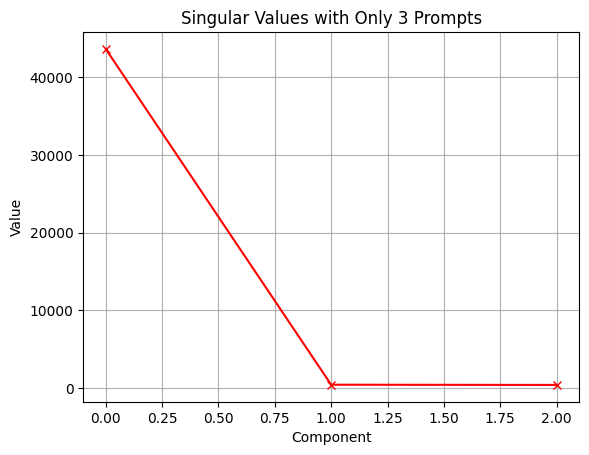

In [10]:
# Try with only 3 prompts
prompts_subset = prompts[:3]
logits_small = []

with torch.no_grad():
    for prompt in prompts_subset:
        inputs = tokenizer(prompt, return_tensors="pt")
        logits = model(**inputs).logits
        logits_last = logits[0, -1, :]
        logits_small.append(logits_last.numpy())

logit_matrix_small = np.stack(logits_small)
_, s_small, _ = np.linalg.svd(logit_matrix_small, full_matrices=False)

plt.plot(s_small, marker='x', color='red')
plt.title("Singular Values with Only 3 Prompts")
plt.xlabel("Component")
plt.ylabel("Value")
plt.grid(True)
plt.show()


This experiment highlights a practical limitation: extraction attacks require a minimum data footprint to be effective. In low-query settings (e.g., APIs with pay-per-token limits), the attack weakens significantly — revealing a boundary condition that defenses can exploit.